<a href="https://colab.research.google.com/github/quynhu-d/hse_risk_management_1/blob/main/notebooks/RM_part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Проект

## Библиотеки

In [ ]:
import pandas as pd
import numpy as np

import datetime
from datetime import datetime

from tqdm.auto import tqdm, trange
from copy import copy, deepcopy

import yfinance as yf

import sys
import warnings
warnings.simplefilter("ignore")


import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
sns.set_style('whitegrid')

In [ ]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.api import OLS

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [ ]:
from IPython.display import display, Latex

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
folder = '/content/drive/MyDrive/RM_project/'

In [ ]:
random_seed = 42
np.random.RandomState(seed=random_seed)

RandomState(MT19937) at 0x7F19C460FC40

## Загрузка данных

In [ ]:
data = pd.read_excel(folder+'Final_data.xlsx')

In [ ]:
print(data.shape, '\n')

print(data.columns, '\n')

(2922, 32) 

Index(['Date', 'Курс доллара', 'Курс евро', 'Нефть', 'МосБиржа', 'РТС',
       'Золото', 'Серебро', 'Платина', 'КБД 0.25', 'КБД 0.5', 'КБД 1', 'КБД 5',
       'КБД 10', 'КБД 15', 'КБД 20', 'КБД 30', 'ОФЗ_26207', 'ОФЗ_26215',
       'ОФЗ_26218', 'ОФЗ_26219', 'ОФЗ_26222', 'Аэрофлот', 'Газпром',
       'ГМК Норникель', 'Лукойл', 'МТС', 'ПИК', 'Роснефть', 'Сбербанк',
       'Татнефть', 'Яндекс'],
      dtype='object') 



In [ ]:
# Заполнение пропусков
data.fillna(method='bfill', inplace=True)
data.fillna(method='ffill', inplace=True)

## Часть 3: Стохастические модели динамики

### Винеровский процесс

In [ ]:
def Wiener_process(w0, dt, N_traj):
    d = 1
    N_t = len(dt) + 1
    W_s = np.zeros([N_traj, d, N_t])
    W_s[..., 0] = w0
    for kk in np.arange(1, N_t):
        noises = np.random.randn(N_traj, d)
        W_s[...,kk] = W_s[..., kk-1] + np.sqrt(dt[kk-1]) * noises
    return W_s[:,0,:]

In [ ]:
N_traj = 15
w0 = 0
t0 = 0
N = data.shape[0]
t_step = 1
t_array = np.round(np.arange(t0, N, t_step))
dt = np.diff(t_array)

wiener_traj = Wiener_process(w0, dt, N_traj)

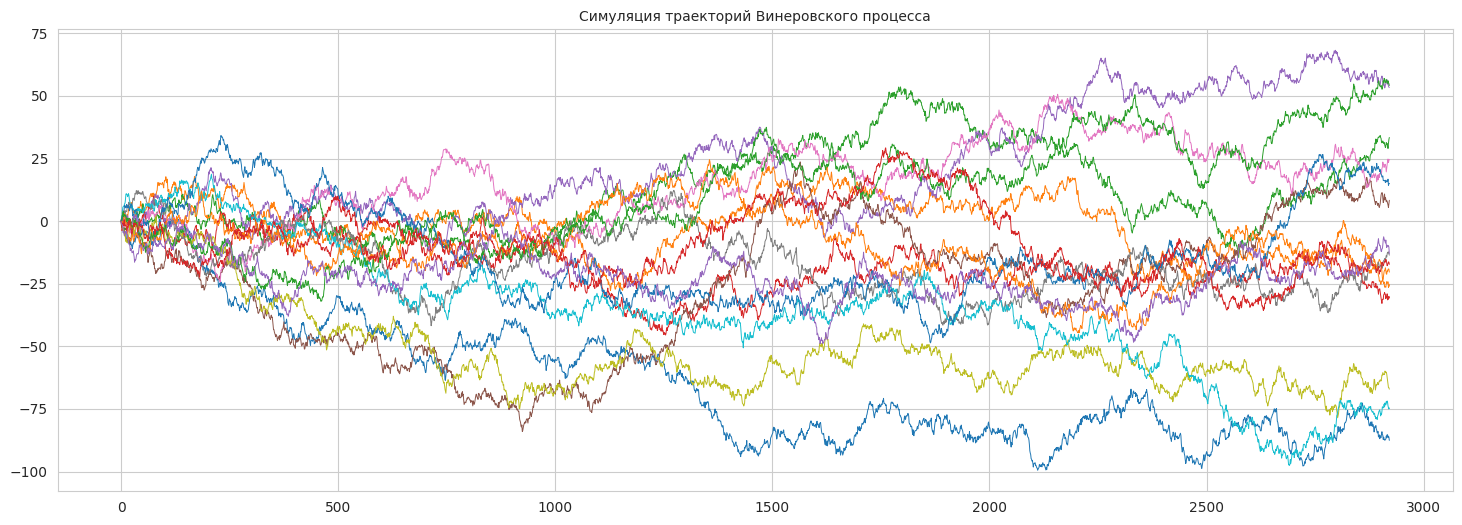

In [ ]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(t_array, wiener_traj.T, linewidth=0.7)
ax.set_title('Симуляция траекторий Винеровского процесса', fontsize=10)
plt.show()

### $1. \ dX_{t} = a \ dt + b \ dW_{t}$

$d X_t = a \ dt + b \ dW_t$\
$\Delta X_t = a \Delta t + b \Delta W_t$\
$X_t = X_{t-1} + a \Delta t + b \Delta W_t$

Если сделать следующие замены: $y=\Delta X_{t}, \ x = \Delta t$, то получим  $y = ax + b \varepsilon_t$ и найдем коэффициенты из линейной регрессии.

In [ ]:
def parametrs_estimation_1(r, dt):
    # замена
    y = np.diff(r)
    X = np.concatenate([dt.reshape(-1, 1)], axis=1)
    # lin reg
    linreg = LinearRegression(fit_intercept=False)
    linreg.fit(X, y)
    y_pred = linreg.predict(X)
    # параметры
    a = linreg.coef_[0]
    b = np.std(y - y_pred)
    return {'a': a, 'b': b}

In [ ]:
def process_1(param, r_0, dt, dWt):
    T = len(dt) + 1
    a, b = param['a'], param['b']

    r_sim = [r_0]
    for t in range(1, T):
        r_t1 = r_sim[t-1]
        r_t = r_t1 + a*dt[t-1] + b*dWt[t-1]
        r_sim.append(r_t)

    return np.asarray(r_sim)

### $ 2. \ dX_{t} = a \ X_{t} \ dt + b \ X_{t} \ dW_{t}$

$d X_t = a \ X_t \ dt + b \ X_t \ dW_t$

$\Delta X_{t} = a \ X_t \Delta t + b \ X_t \Delta W_t$

$\frac{\Delta X_{t}}{X_t} = a \Delta t + b \Delta W_t$

$X_t = X_{t-1} + a X_{t-1} \Delta t + b X_{t-1} \Delta W_t$

Сделаем следующие замены: $y=\frac{\Delta X_{t}}{X_t}, \ x = \Delta t$.\
Получим  $y = ax + b \varepsilon_t$. Найдем коэффициенты из линейной регрессии.

In [ ]:
def parametrs_estimation_2(r, dt):
    # замена
    r_t1 = r[:-1]
    y = np.diff(r) / r_t1
    X = np.concatenate([dt.reshape(-1, 1)], axis=1)
    # lin reg
    linreg = LinearRegression(fit_intercept=False)
    linreg.fit(X, y)
    y_pred = linreg.predict(X)
    # параметры
    a = linreg.coef_[0]
    b = np.std(y - y_pred)
    return {'a': a, 'b': b}

In [ ]:
def process_2(param, r_0, dt, dWt):
    T = len(dt) + 1
    a, b = param['a'], param['b']

    r_sim = [r_0]
    for t in range(1, T):
        r_t1 = r_sim[t-1]
        r_t = r_t1 + a*r_t1*dt[t-1] + b*r_t1*dWt[t-1]
        r_sim.append(r_t)

    return np.asarray(r_sim)

### $3. \ CIR: \ d X_{t} = a (b-X_{t})dt + c\sqrt{X_{t}} d W_{t} $


Стохастическое дифференциальное уравнение для процесса Кокса-Ингерсолла-Росса выглядит следующим образом:

$ d r_{t} = a (b-r_{t})dt + c\sqrt{r_{t}} d W_{t} $

Для моделирования процесса воспользуемся дискретным уравнением:

$ r_{t} = r_{t-1} + a (b-r_{t-1}) \Delta t + c\sqrt{|{r_{t-1}}|} \Delta W_{t} $

Используется для симмуляции процентных ставок.

Подбор параметров осуществляется следующим образом.

$ \Delta r_{t} = a (b-r_t) \Delta t + c\sqrt{r_{t}} \Delta W_{t} $

$ \frac{\Delta r_{t}}{\sqrt{r_{t}}} = ab \frac{\Delta t}{{\sqrt{r_{t}}}} - a \frac{r_{t} \Delta t}{{\sqrt{r_{t}}}}  + c \Delta W_{t}$

$ \frac{\Delta r_{t}}{\sqrt{r_{t}}} = ab \frac{\Delta t}{{\sqrt{r_{t}}}} - a \sqrt{r_{t}} \Delta t  + c \Delta W_{t}$

Можно сделать следующие замены:

$y = \frac{\Delta r_{t}}{\sqrt{r_{t}}}$

$x_1 = \frac{\Delta t}{{\sqrt{r_{t}}}}$

$x_2 = \sqrt{r_{t}} \Delta t$

Тогда получим $y = abx_1 - ax_2 + c \varepsilon_t$ и найдем коэффициенты из линейной регрессии.


In [ ]:
def parametrs_estimation_CIR(r, dt):
    # замена
    sqrt_r_t1 = np.sqrt(r[:-1])
    y = np.diff(r) / sqrt_r_t1
    x_1 = dt / sqrt_r_t1
    x_2 = dt * sqrt_r_t1
    X = np.concatenate([x_1.reshape(-1, 1), x_2.reshape(-1, 1)], axis=1)
    # lin reg
    linreg = LinearRegression(fit_intercept=False)
    linreg.fit(X, y)
    y_pred = linreg.predict(X)
    # параметры: #p1 = ab, p2 = -a
    ab = linreg.coef_[0]
    a = -linreg.coef_[1]
    b = ab / a
    c = np.std(y - y_pred)
    if 2*a*b < c**2:
        #print('Ошибка в параметрах')
        print('Внимание: 2ab < c^2')
    return {'a': a, 'b': b, 'c': c}

In [ ]:
def process_CIR(param, r_0, dt, dWt):
    T = len(dt) + 1
    a, b, c = param['a'], param['b'], param['c']

    r_sim = [r_0]
    for t in range(1, T):
        r_t1 = r_sim[t-1]
        r_t = r_t1 + a*(b - r_t1)*dt[t-1] + c*np.sqrt(np.abs(r_t1))*dWt[t-1]
        r_sim.append(r_t)

    return np.asarray(r_sim)

### $4. \ FX$

В общем виде модель выглядит следующим образом:

$d(\ln X_t) = \frac{dX_t}{X_t} = k(\theta - \ln X_t)dt + \sigma_{FX}(t)dW_t$

Пусть $Y_t = \ln X_t$.

$dY_t = k(\theta - Y_t)dt + \sigma dW_t$

В дискретном случае:

$Y_t = Y_{t-1} + k(\theta - Y_{t-1})\Delta t + \sigma \Delta W_t$

$X_t = exp \{Y_t\}$

Подбор параметров:\
$\Delta Y_{t} = k(\theta - Y_t)\Delta t + \sigma \Delta W_{t} $

$\Delta Y_{t} = k \theta \Delta t - k Y_t \Delta t + \sigma \Delta W_{t} $

Тогда заменяем $y = \Delta Y_{t}, \ x_1 = \Delta t, \ x_2 = Y_t \Delta t$.

In [ ]:
def parametrs_estimation_FX(r, dt):
    # замена
    y = np.diff(r)
    x_1 = dt
    x_2 = dt * r[:-1]
    X = np.concatenate([x_1.reshape(-1, 1), x_2.reshape(-1, 1)], axis=1)
    # lin reg
    linreg = LinearRegression(fit_intercept=False)
    linreg.fit(X, y)
    y_pred = linreg.predict(X)
    # параметры
    a = -linreg.coef_[1]
    b = linreg.coef_[0] / a
    c = np.std(y - y_pred)
    return {'k': a, 'theta': b, 'sigma': c}

In [ ]:
def process_FX(param, r_0, dt, dWt):
    T = len(dt) + 1
    k, th, sigma = param['k'], param['theta'], param['sigma']

    y_sim = [r_0]
    for t in range(1, T):
        y_t1 = y_sim[t-1]
        y_t = y_t1 + k*(th - y_t1)*dt[t-1] + sigma*dWt[t-1]
        y_sim.append(y_t)

    return np.exp(y_sim)

### Общий модуль

In [ ]:
def calculate_metric(y_true, y_sim_N, mode='rmse'):
    res = []
    if mode == 'rmse':
        for y_sim in y_sim_N:
            res.append(mean_squared_error(y_true, y_sim, squared=False))
        return np.mean(res)
    elif mode == 'mae':
        for y_sim in y_sim_N:
            res.append(mean_absolute_error(y_true, y_sim))
        return np.mean(res)
    elif mode == 'mape':
        for y_sim in y_sim_N:
            res.append(mean_absolute_percentage_error(y_true, y_sim))
        return np.mean(res)
    else:
        return None

In [ ]:
class Stoch_Models:
    def __init__(self, factor_name,
                 value_train, value_test,
                 t_train, t_test,
                 N_traj=10, models=None):
        self.name = factor_name
        self.val_tain = value_train
        self.val_test = value_test
        self.val_t0 = value_train[0]
        self.val_last = value_train[-1]
        self.t_train = t_train
        self.t_test = t_test
        self.t_array = t_train + t_test
        self.N_traj = N_traj

        # модели
        if models is None:
            self.models = ['m1', 'm2', 'm3', 'm4']
        else:
            self.models = models

        self.models_info = {
            'm1': '$a dt + b dW_t$',
            'm2': '$a X_t dt + b X_t dW_t$',
            'm3': 'CIR',
            'm4': 'FX'
        }

        self.dW_N = self.Wiener_simulation()

        # параметры
        self.parametrs_func = {
            'm1': parametrs_estimation_1,
            'm2': parametrs_estimation_2,
            'm3': parametrs_estimation_CIR,
            'm4': parametrs_estimation_FX
        }
        self.paramters = {}

        # симуляции
        self.simulations_func = {
            'm1': process_1,
            'm2': process_2,
            'm3': process_CIR,
            'm4': process_FX
        }
        self.simulations = {}

        self.metric = 'rmse'
        self.res_metric = {}

        self.colors = {
            'm1': 'goldenrod',
            'm2': 'seagreen',
            'm3': 'steelblue',
            'm4': 'indianred',
            'factor': 'black'
        }

    def Wiener_simulation(self):
        w0=0
        dt_ = np.diff(self.t_array)
        wiener_traj = Wiener_process(w0, dt_, self.N_traj)
        dW_N = np.diff(wiener_traj, axis=1)
        return dW_N

    def find_parametrs(self):
        for m in self.models:
            self.paramters[m] = self.parametrs_func[m](self.val_train, np.diff(self.t_train))

    def make_simulations(self):

        # АДАПТИРОВАТЬ ПОД КОЛ_ВО ШАГОВ
        self.find_parametrs()

        for m in self.models:
            r_traj = []
            for dWt in self.dW_N:
                r_tr = self.simulations_func[m](param=self.paramters[m], r_0=self.val_t0, dt=np.diff(self.t_train), dWt=dWt)
                r_traj.append(np.array(r_tr))
            self.simulations[m] = np.array(r_traj)

    def plot_simulations(self, fig_size=(20, 8)):
        fig, axs = plt.subplots(1, 1, figsize=fig_size)
        for m in self.models:
            axs.plot(self.t_train, self.simulations[m].T, color=self.colors[m], linewidth=0.5)
            axs.plot(self.t_train, np.mean(self.simulations[m], axis=0), color=self.colors[m], linewidth=2, label=self.models_info[m])
        axs.plot(self.t_train, self.val_train, color=self.colors['factor'], linewidth=1.5, label='factor')
        axs.legend()
        axs.set_title(self.name)
        plt.show()

    def print_metric_result(self):
        print(self.metric, '\n')
        for m in self.models:
            print(f'{m}: {round(self.res_metric[m], 4)}')

    def find_best_model(self):
        min_m = min(self.res_metric.values())
        best_model = None
        for m in self.res_metric.keys():
            if self.res_metric[m] == min_m:
                best_model = m
        return best_model

    def plot_simulations_best(self, fig_size=(20, 8)):
        m = self.find_best_model()
        fig, axs = plt.subplots(1, 1, figsize=fig_size)
        axs.plot(self.t_train, self.simulations[m].T, color=self.colors[m], linewidth=0.5)
        axs.plot(self.t_train, np.mean(self.simulations[m], axis=0), color=self.colors[m], linewidth=2, label=self.models_info[m])
        axs.plot(self.t_train, self.val_train, color=self.colors['factor'], linewidth=1.5, label='factor')
        axs.legend()
        axs.set_title(f'{self.name}, лучшая модель ({self.metric} = {round(self.res_metric[m], 2)})')
        plt.show()

    def choose_model(self, print_metric=1, plot=1, fig_size=(20, 8), metric=None):
        if metric is not None:
            self.metric = metric
        self.make_simulations()

        for m in self.models:
            self.res_metric[m] = calculate_metric(self.val, self.simulations[m], mode=self.metric)

        if print_metric == 1:
            self.print_metric_result()
        if plot == 1:
            self.plot_simulations(fig_size)
            self.plot_simulations_best(fig_size)

    def plot_simulations_future(self, r_traj, m, fig_size=(20, 8)):
        fig, axs = plt.subplots(1, 1, figsize=fig_size)
        axs.plot(self.t_array, self.val, color=self.colors['factor'], linewidth=1.5, label='factor')
        axs.plot(r_traj.T, color=self.colors[m], linewidth=0.5)
        axs.legend()
        #axs.set_title(self.name)
        plt.show()

    def future_simulation(self, n_steps=1, best_model=None, plot=0):
        if best_model is None:
            best_model = self.find_best_model()
        dt_ = np.diff(np.round(np.arange(0, n_steps, 1)))
        y0 = self.val[-1]
        dWts = self.Wiener_simulation(dt_=dt_)

        r_traj = []
        for dWt in dWts:
            r_tr = self.simulations_func[best_model](param=self.paramters[best_model], r_0=y0, dt=dt_, dWt=dWt)
            r_traj.append(np.array(r_tr))





#### Пример 1

In [ ]:
wp = Wiener_process(0, np.diff(np.round(np.arange(0, 5, 1))), 3)
wp[:, :-2]

In [ ]:
f_col = 'Курс доллара'

t0 = 0
N = data.shape[0]
t_step = 1
t_array = np.round(np.arange(t0, N, t_step))

In [ ]:
sm = Stoch_Models(factor_name=f_col, factor_value=data[f_col].values, t_array=t_array, models=['m1', 'm2', 'm3'], N_traj=25)

rmse 

m1: 25.9138
m2: 23.1035
m3: 10.475


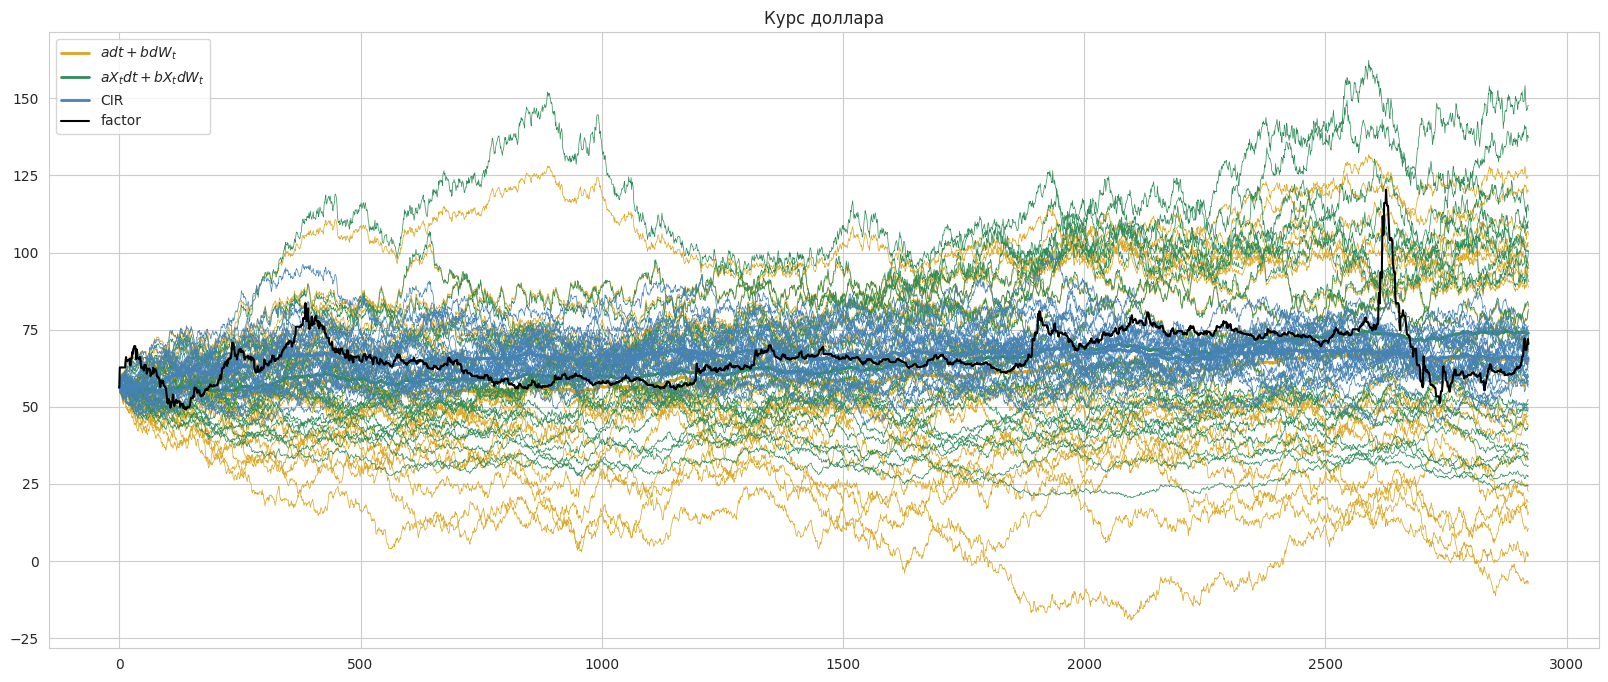

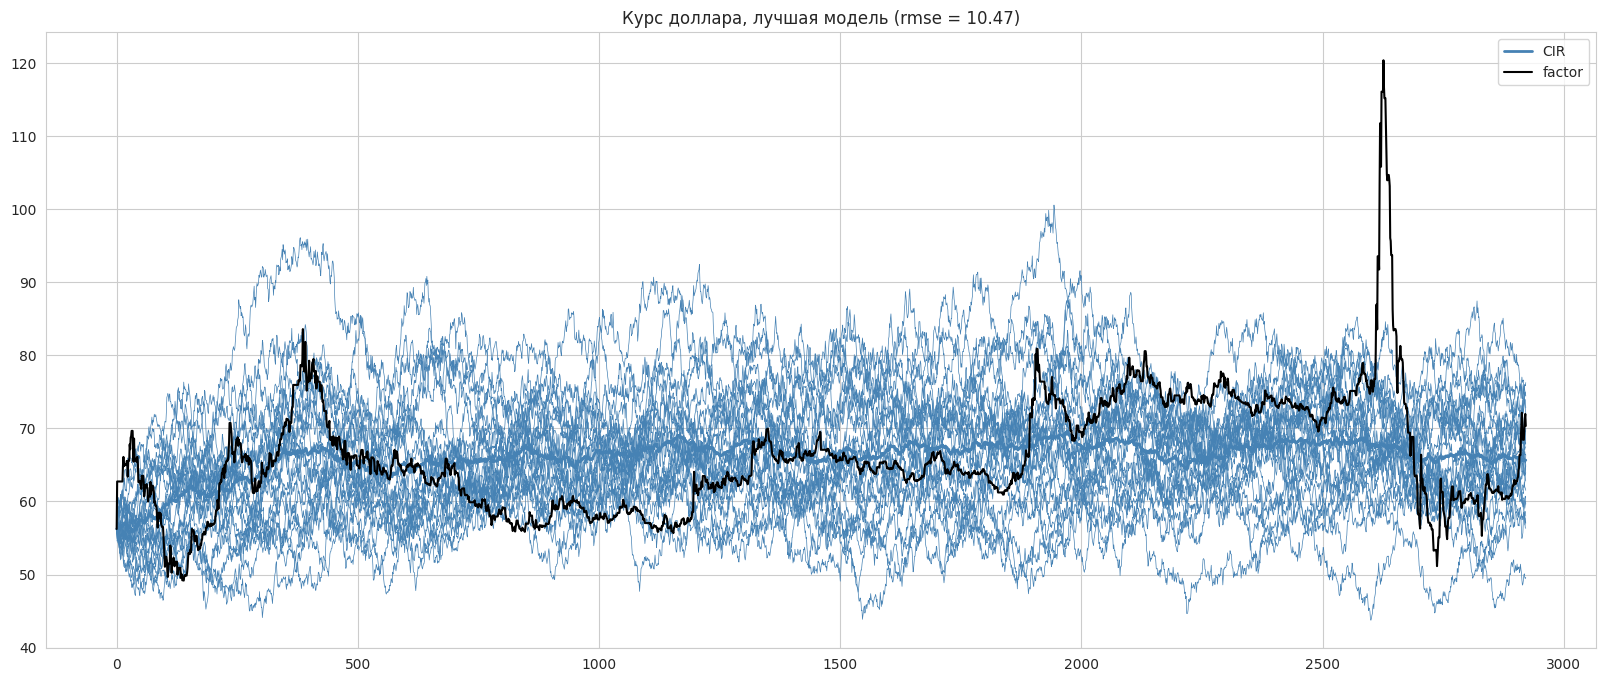

In [ ]:
sm.choose_model()

#### Пример 2

rmse 

m1: 46.9768
m2: 57.8742
m3: 25.0818


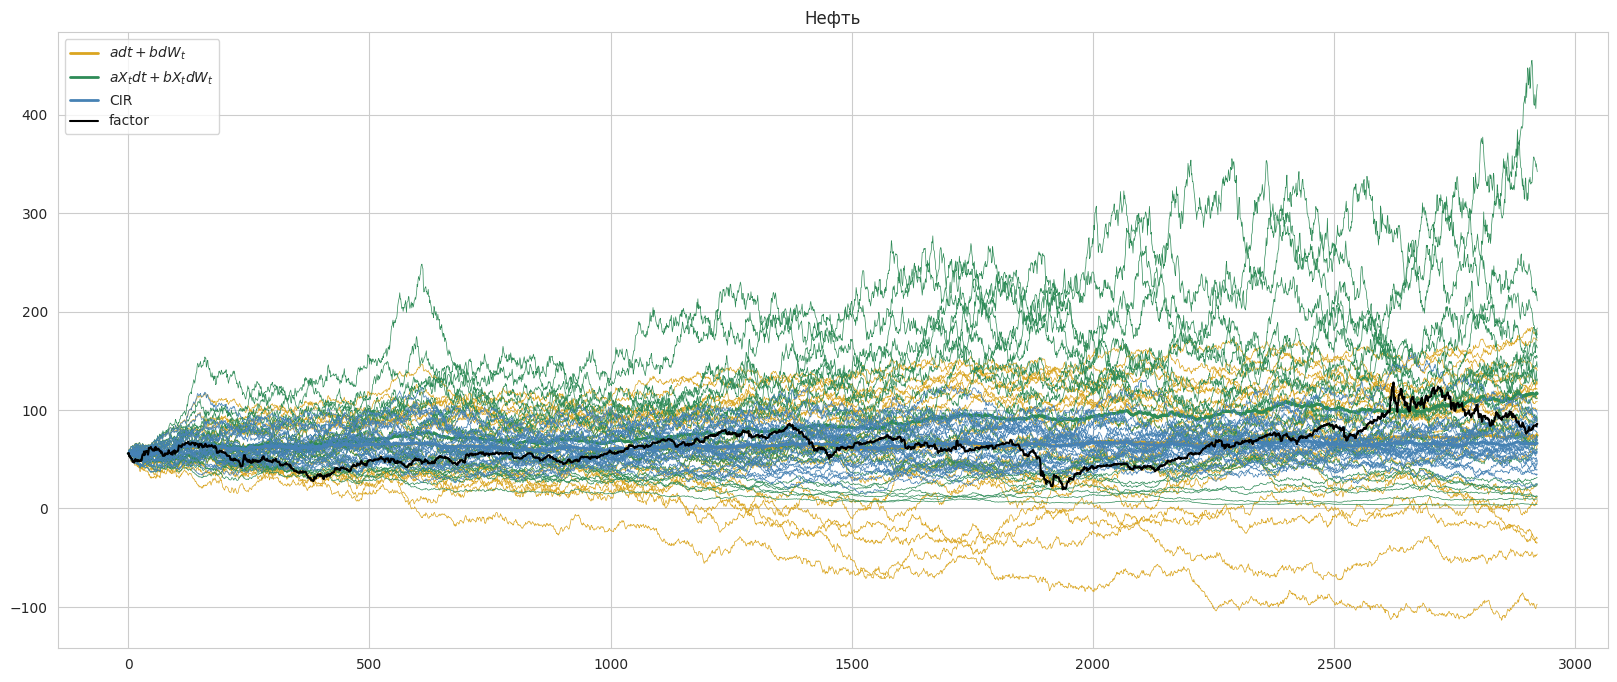

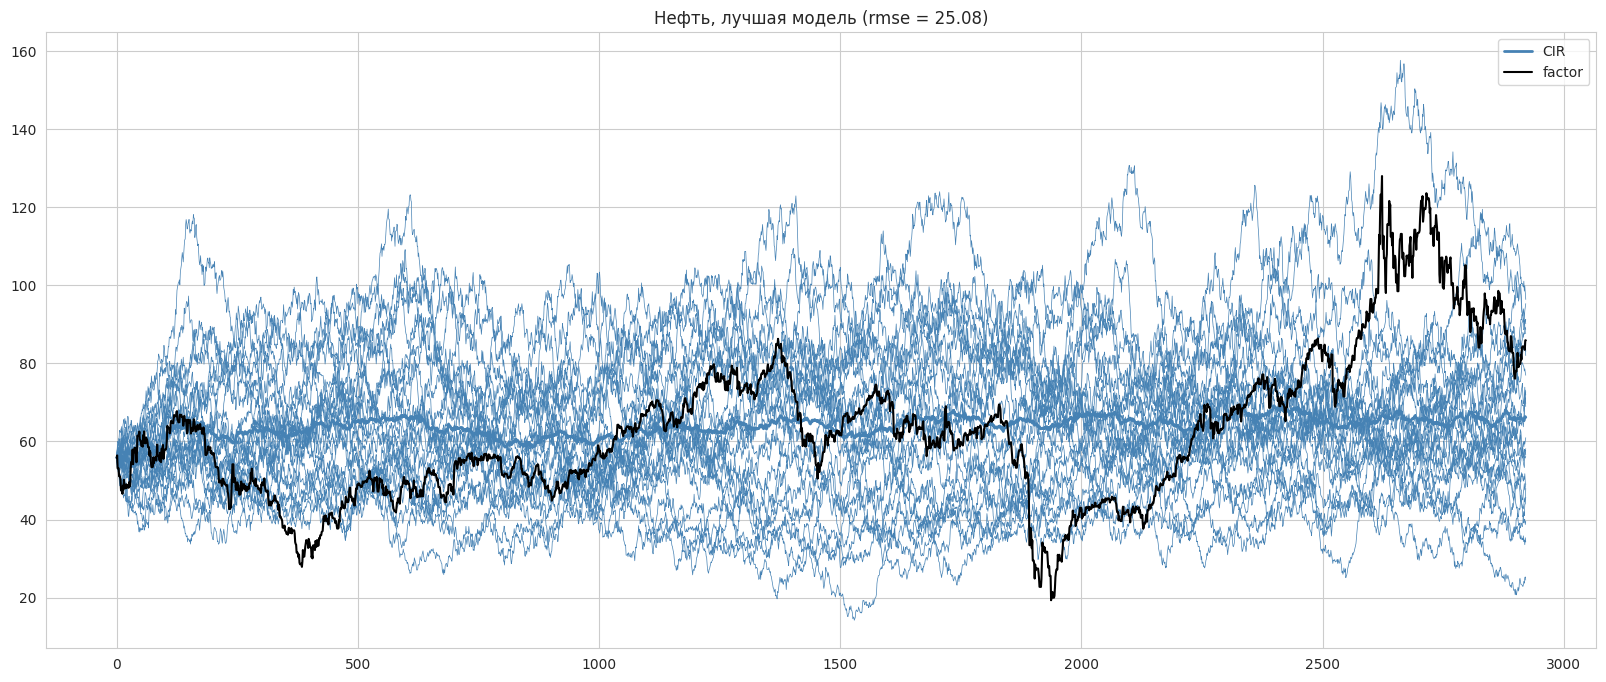

In [ ]:
f_col = 'Нефть'
sm = Stoch_Models(factor_name=f_col, factor_value=data[f_col].values, t_array=t_array, models=['m1', 'm2', 'm3'], N_traj=25)
sm.choose_model()

### Пример 3

посмотреть приращения

### Симуляция риск-факторов


Портфель состоит из инструментов.\
Инструменты:
1. Облигации (5 шт. по 10 млн.руб.)
2. Акции (10 шт. по 1 млн. руб.)
3. Валюта (доллар и евро, по 100 млн. руб.)

Риск-факторы влияют на стоимость инструментов.

In [ ]:
risk_factors = ['Курс доллара', 'Курс евро', 'Нефть', 'МосБиржа', 'РТС',
       'Золото', 'Серебро', 'Платина', 'КБД 0.25', 'КБД 1', 'КБД 5', 'КБД 10', 'КБД 20']

print(len(risk_factors))

13


К риск-факторам отнесем то, что входит в список *risk_factors*. Будущие значения для них будут формироваться модулем *Stoch_Models*.

In [ ]:
def split_data(df, split_date, start_date=None, end_date=None):
    train = df[df.Date <= split_date]
    test = df[df.Date > split_date]
    if start_date is not None:
        train = train[train.Date >= start_date]
    if end_date is not None:
        test = test[test.Date <= end_date]
    return train, test

In [ ]:
#разбиваем данные на train и test по дате

df_train, df_test = split_data(data, split_date='2022-06-09')
print(df_train.shape[0], df_test.shape[0])

2716 206


In [ ]:
# для всех риск факторов моделируем значения на будущее

N_traj = 100

df_res = {}

for factor in risk_factors:
    sm = Stoch_Models(factor_name=factor, factor_value=data[factor].values, t_array=t_array, models=['m1', 'm2', 'm3'], N_traj=N_traj)
    #sm.choose_model()
    #моделируемое значение (их много, что с этим делать?)




В классе вмето t и y нужно сделать t_train, t_test, y_train, y_test
